In [1]:
#Importing Required modules
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdmolops
from rdkit.Chem import RDConfig
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold

from collections import defaultdict
from itertools import product
import igraph
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import re
IPythonConsole.ipython_useSVG = True

In [2]:
#creting a function to...
def gengraph(mols,fpgen , threshold=0.7):
    fps = [fpgen.GetFingerprint(m) for m in mols]
    num_v = len(mols)
    graph = igraph.Graph()
    graph.add_vertices(num_v)
    for i in range(num_v):
        for j in range(i):
            if DataStructs.TanimotoSimilarity(fps[i], fps[j]) >= threshold:
                graph.add_edge(i, j)
    return graph

In [3]:
#Creating a function that joins two molecules together
def makebond(target, chain):
    newmol = Chem.RWMol(rdmolops.CombineMols(target, chain))
    atoms = newmol.GetAtoms()
    mapper = defaultdict(list)
    for idx, atm in enumerate(atoms):
        atom_map_num = atm.GetAtomMapNum()
        mapper[atom_map_num].append(idx)
    for idx, a_list in mapper.items():
        if len(a_list) == 2:
            atm1, atm2 = a_list
            rm_atoms = [newmol.GetAtomWithIdx(atm1),newmol.GetAtomWithIdx(atm2)]
            nbr1 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm1)) for x in newmol.GetAtomWithIdx(atm1).GetBonds()][0]
            nbr1.SetAtomMapNum(idx)
            nbr2 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm2)) for x in newmol.GetAtomWithIdx(atm2).GetBonds()][0]
            nbr2.SetAtomMapNum(idx)
    newmol.AddBond(nbr1.GetIdx(), nbr2.GetIdx(), order=Chem.rdchem.BondType.SINGLE)
    nbr1.SetAtomMapNum(0)
    nbr2.SetAtomMapNum(0)
    newmol.RemoveAtom(rm_atoms[0].GetIdx())
    newmol.RemoveAtom(rm_atoms[1].GetIdx())
    newmol = newmol.GetMol()
    return newmol

In [4]:
#Creating a function that enumerates molcules
def enumeratemol(core,rg, maxmol=10000):
    dataset = rg.GetRGroupsAsColumns()
    labels = list(dataset.keys())
    pat = re.compile("R\d+")
    labels = [label for label in labels if pat.match(label)]
    rgs = np.asarray([dataset[label] for label in labels])
    i, j = rgs.shape
    combs = [k for k in product(range(j), repeat=i)]
    res = []
    for i in combs:
        mol = core
        for idx,j in enumerate(i):
            mol = makebond(mol, rgs[idx][j])
        AllChem.Compute2DCoords(mol)
        mol = Chem.RemoveHs(mol)
        res.append(mol)
    return res

In [5]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(2)

In [6]:
mols = [m for m in Chem.SDMolSupplier('core2.sdf')]
for mol in mols:
    AllChem.Compute2DCoords(mol)
fps = [fpgen.GetFingerprint(m) for m in mols]


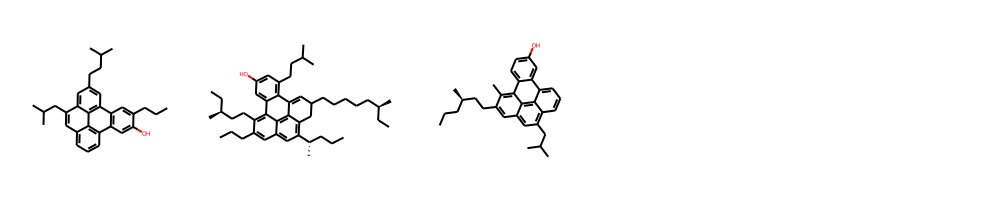

In [7]:
Draw.MolsToGridImage(mols, molsPerRow=5)

In [8]:
graph = gengraph(mols, fpgen, 0.4)
blks=graph.blocks()
simmols_idx = sorted(list(blks), key=lambda x: len(x), reverse=True)
simmols_idx

[[0, 2]]

In [9]:
simmols = [mols[i] for i in simmols_idx[0]]
scaff = [MurckoScaffold.GetScaffoldForMol(m) for m in simmols]
scaff

In [10]:
mcs1 = rdFMCS.FindMCS(scaff, threshold=0.7)
mcs2 = rdFMCS.FindMCS(scaff, threshold=0.7, 
                      completeRingsOnly=True,
                      matchValences=True,
                      bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                      atomCompare=rdFMCS.AtomCompare.CompareElements,
                      )
mcs3 = rdFMCS.FindMCS(scaff, threshold=0.7,
                      ringMatchesRingOnly=True,
                      completeRingsOnly=True,
                      atomCompare=rdFMCS.AtomCompare.CompareAny)

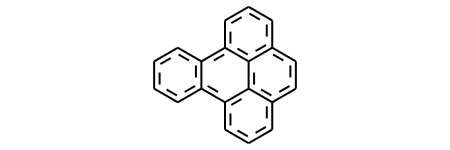

In [11]:
Chem.MolFromSmarts(mcs1.smartsString)

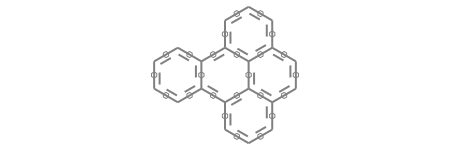

In [12]:
Chem.MolFromSmarts(mcs2.smartsString)

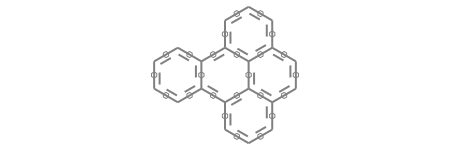

In [13]:
Chem.MolFromSmarts(mcs3.smartsString)

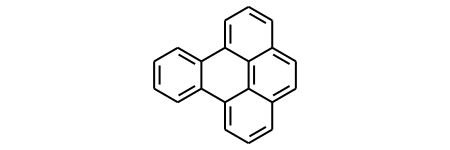

In [14]:
mols_has_core = []
core = Chem.MolFromSmarts(mcs2.smartsString)
for mol in mols:
    if mol.HasSubstructMatch(core):
        AllChem.Compute2DCoords(mol)
        mols_has_core.append(mol)
def getMCSSmiles(mol, mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    smi = Chem.MolFragmentToSmiles(mol, atomsToUse=match)
    return smi
mcs_smi = getMCSSmiles(mols_has_core[0], mcs1)
core = Chem.MolFromSmiles(mcs_smi)
core

In [15]:
rgp = rdRGroupDecomposition.RGroupDecompositionParameters()
rgp.removeHydrogensPostMatch = True
rgp.alignment =True
rgp.removeAllHydrogenRGroups=True
rg = rdRGroupDecomposition.RGroupDecomposition(core, rgp)
for mol in mols_has_core:
    rg.Add(mol)
rg

In [16]:
rg.Process()

True

In [17]:
frame = pd.DataFrame(rg.GetRGroupsAsColumns())
frame["Smiles"] = [Chem.MolToSmiles(mol) for mol in mols_has_core]
PandasTools.AddMoleculeColumnToFrame(frame)

,ROMol,Smiles,Core,R1,R2
0,,CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cc(CCC(C)C)c...,,,
1,,CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cccc4c5cc(O)ccc...,,,

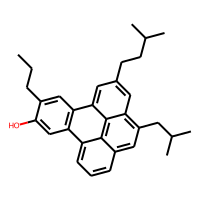
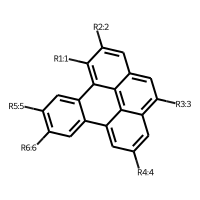
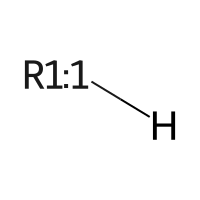
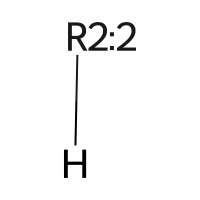
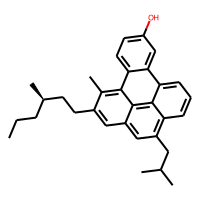
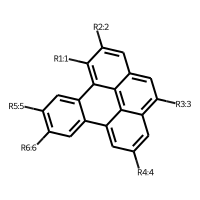
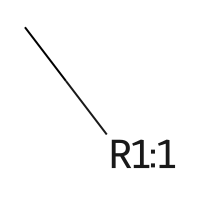
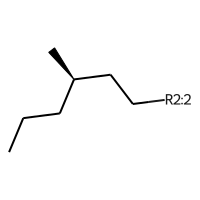

In [18]:
frame = frame[["ROMol", "Smiles", "Core", "R1", "R2"]]
frame['Core']=frame['Core'].apply(Chem.RemoveHs)
frame.head()

In [19]:
dataset = rg.GetRGroupsAsColumns()
core =  Chem.RemoveHs(dataset["Core"][0])

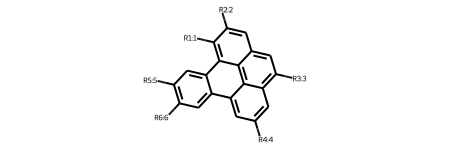

In [20]:
core

In [21]:
res = enumeratemol(core,rg)

C:\Users\Kakashi\anaconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


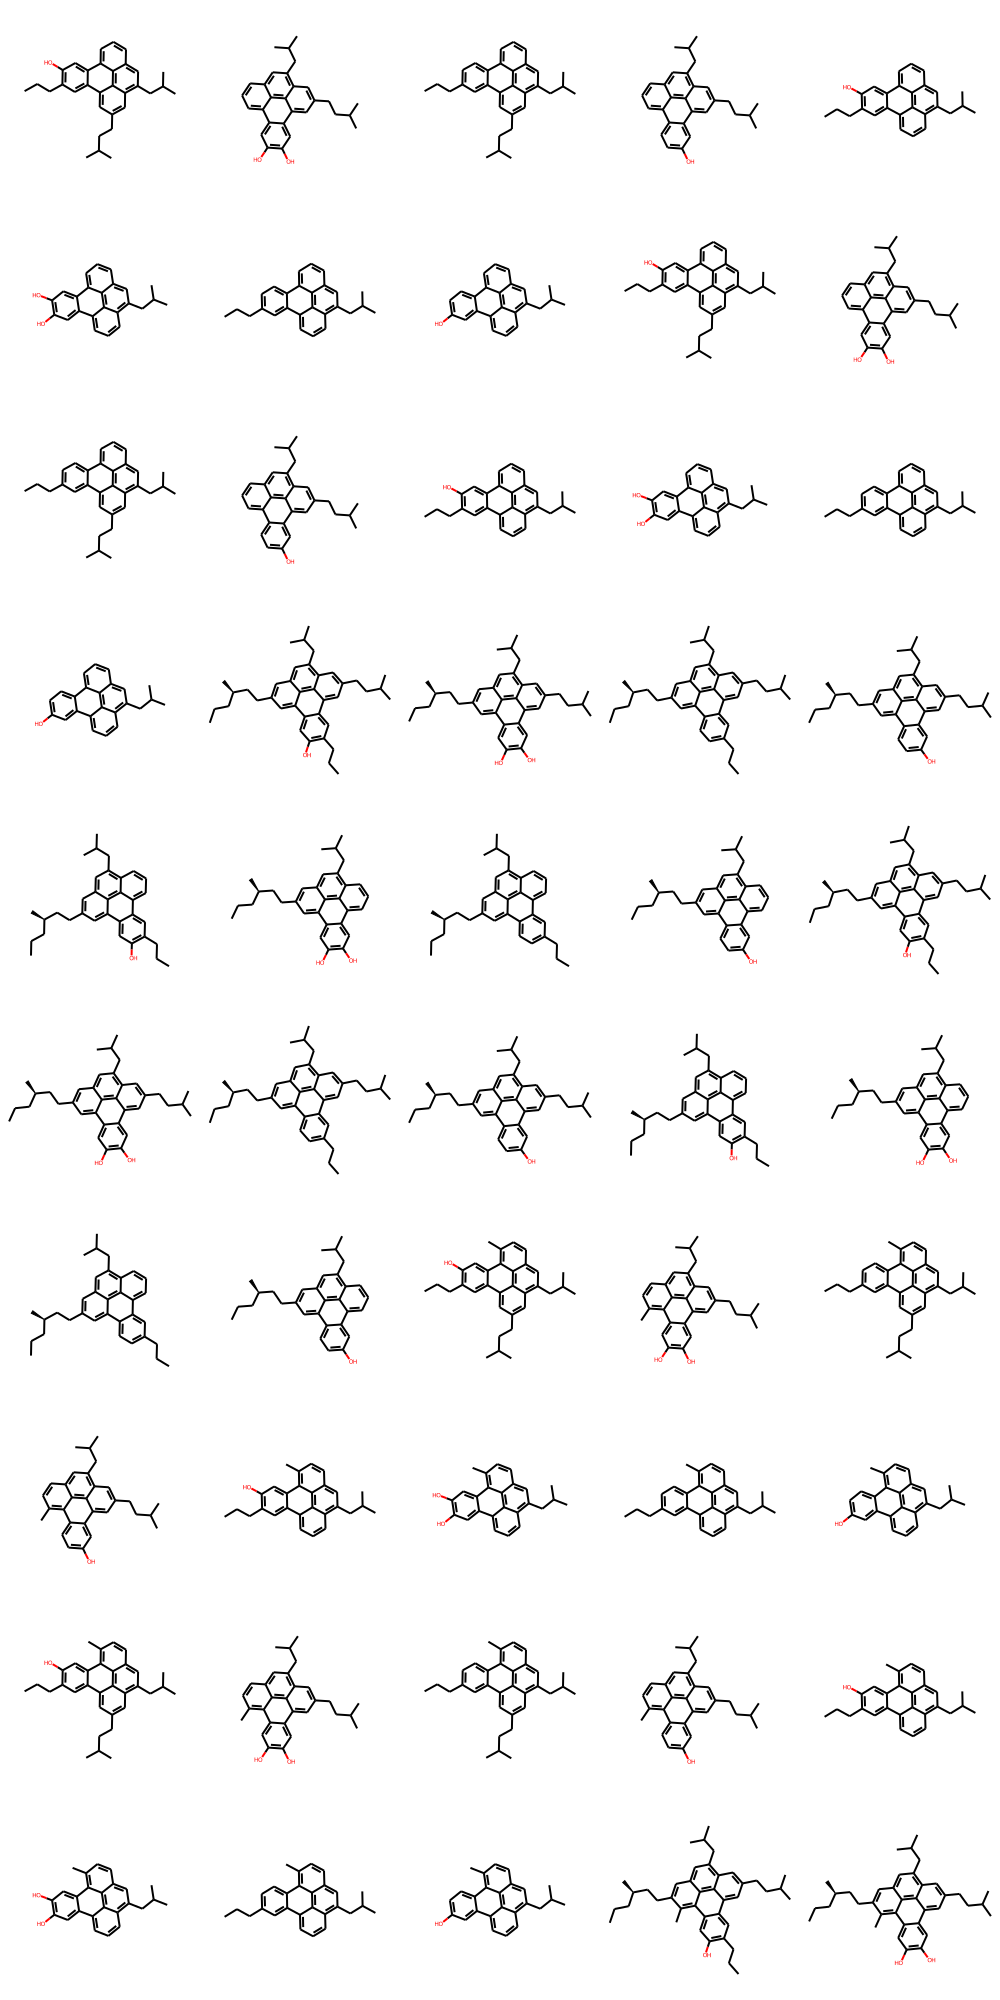

In [22]:
Draw.MolsToGridImage(res[:200],molsPerRow=5)

In [23]:
print(len(res),'molecules generated')

64 molecules generated


In [24]:
print(res)

[<rdkit.Chem.rdchem.Mol object at 0x000002046941EF20>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EF80>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EC80>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EE00>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EDA0>, <rdkit.Chem.rdchem.Mol object at 0x000002046941ED40>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EC20>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EAA0>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EA40>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EBC0>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EB60>, <rdkit.Chem.rdchem.Mol object at 0x000002046941EB00>, <rdkit.Chem.rdchem.Mol object at 0x000002046941E9E0>, <rdkit.Chem.rdchem.Mol object at 0x000002046941E560>, <rdkit.Chem.rdchem.Mol object at 0x000002046941E860>, <rdkit.Chem.rdchem.Mol object at 0x000002046941E980>, <rdkit.Chem.rdchem.Mol object at 0x000002046941E920>, <rdkit.Chem.rdchem.Mol object at 0x000002046941E8C0>, <rdkit.Chem.rdchem.Mol obje

In [25]:
listsmiles=[]
for m in res:
    print(Chem.MolToSmiles(m))
    listsmiles.append(Chem.MolToSmiles(m))
len(listsmiles)

CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31
CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5cc(O)c(O)cc5c(c1)c2c34
CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4cccc2c4c31
CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5ccc(O)cc5c(c1)c2c34
CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cccc2c4c31
CC(C)Cc1cc2cccc3c4cc(O)c(O)cc4c4cccc1c4c23
CCCc1ccc2c(c1)c1cccc3c(CC(C)C)cc4cccc2c4c31
CC(C)Cc1cc2cccc3c4ccc(O)cc4c4cccc1c4c23
CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31
CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5cc(O)c(O)cc5c(c1)c2c34
CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4cccc2c4c31
CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5ccc(O)cc5c(c1)c2c34
CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cccc2c4c31
CC(C)Cc1cc2cccc3c4cc(O)c(O)cc4c4cccc1c4c23
CCCc1ccc2c(c1)c1cccc3c(CC(C)C)cc4cccc2c4c31
CC(C)Cc1cc2cccc3c4ccc(O)cc4c4cccc1c4c23
CCCc1cc2c(cc1O)c1cc(CC[C@H](C)CCC)cc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31
CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cc(CCC(C)C)cc4c5cc(O)c(O)cc5c(c1)c2c34
CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4cc(CC[C@H](C)CCC)cc2c4c31
CCC[C@@H](C)CCc1cc2cc(CC(

64

In [26]:
print(listsmiles)

['CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31', 'CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5cc(O)c(O)cc5c(c1)c2c34', 'CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4cccc2c4c31', 'CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5ccc(O)cc5c(c1)c2c34', 'CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cccc2c4c31', 'CC(C)Cc1cc2cccc3c4cc(O)c(O)cc4c4cccc1c4c23', 'CCCc1ccc2c(c1)c1cccc3c(CC(C)C)cc4cccc2c4c31', 'CC(C)Cc1cc2cccc3c4ccc(O)cc4c4cccc1c4c23', 'CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31', 'CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5cc(O)c(O)cc5c(c1)c2c34', 'CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4cccc2c4c31', 'CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5ccc(O)cc5c(c1)c2c34', 'CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cccc2c4c31', 'CC(C)Cc1cc2cccc3c4cc(O)c(O)cc4c4cccc1c4c23', 'CCCc1ccc2c(c1)c1cccc3c(CC(C)C)cc4cccc2c4c31', 'CC(C)Cc1cc2cccc3c4ccc(O)cc4c4cccc1c4c23', 'CCCc1cc2c(cc1O)c1cc(CC[C@H](C)CCC)cc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31', 'CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cc(CCC(C)C)cc4c5cc(O)c(O)cc5c(c1)c2c34', 'CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)

In [27]:
unique=set(listsmiles)

In [28]:
for i in (unique):
    print(i)

CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cccc2c4c31
CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4ccc(C)c2c4c31
CCCc1cc2c(cc1O)c1c(C)c(CC[C@H](C)CCC)cc3cc(CC(C)C)c4cccc2c4c31
CCCc1cc2c(cc1O)c1c(C)ccc3cc(CC(C)C)c4cccc2c4c31
Cc1ccc2cc(CC(C)C)c3cc(CCC(C)C)cc4c5cc(O)ccc5c1c2c34
CCCc1ccc2c(c1)c1cccc3c(CC(C)C)cc4ccc(C)c2c4c31
CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cc(CCC(C)C)cc4c5cc(O)ccc5c(c1C)c2c34
CCCc1cc2c(cc1O)c1cc(CC[C@H](C)CCC)cc3cc(CC(C)C)c4cccc2c4c31
CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cc(CCC(C)C)cc4c5cc(O)c(O)cc5c(c1)c2c34
CCCc1ccc2c(c1)c1cccc3c(CC(C)C)cc4cc(CC[C@H](C)CCC)cc2c4c31
CCCc1cc2c(cc1O)c1cccc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31
CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cccc4c5cc(O)ccc5c(c1C)c2c34
CCCc1cc2c(cc1O)c1c(C)ccc3cc(CC(C)C)c4cc(CCC(C)C)cc2c4c31
CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cccc4c5cc(O)c(O)cc5c(c1C)c2c34
CC(C)CCc1cc2c(CC(C)C)cc3cccc4c5cc(O)c(O)cc5c(c1)c2c34
CCC[C@@H](C)CCc1cc2cc(CC(C)C)c3cccc4c5cc(O)ccc5c(c1)c2c34
CCCc1ccc2c(c1)c1cc(CCC(C)C)cc3c(CC(C)C)cc4cccc2c4c31
CC(C)Cc1cc2cccc3c4cc(O)c(O)cc4c4ccc

32 unique molecules generated


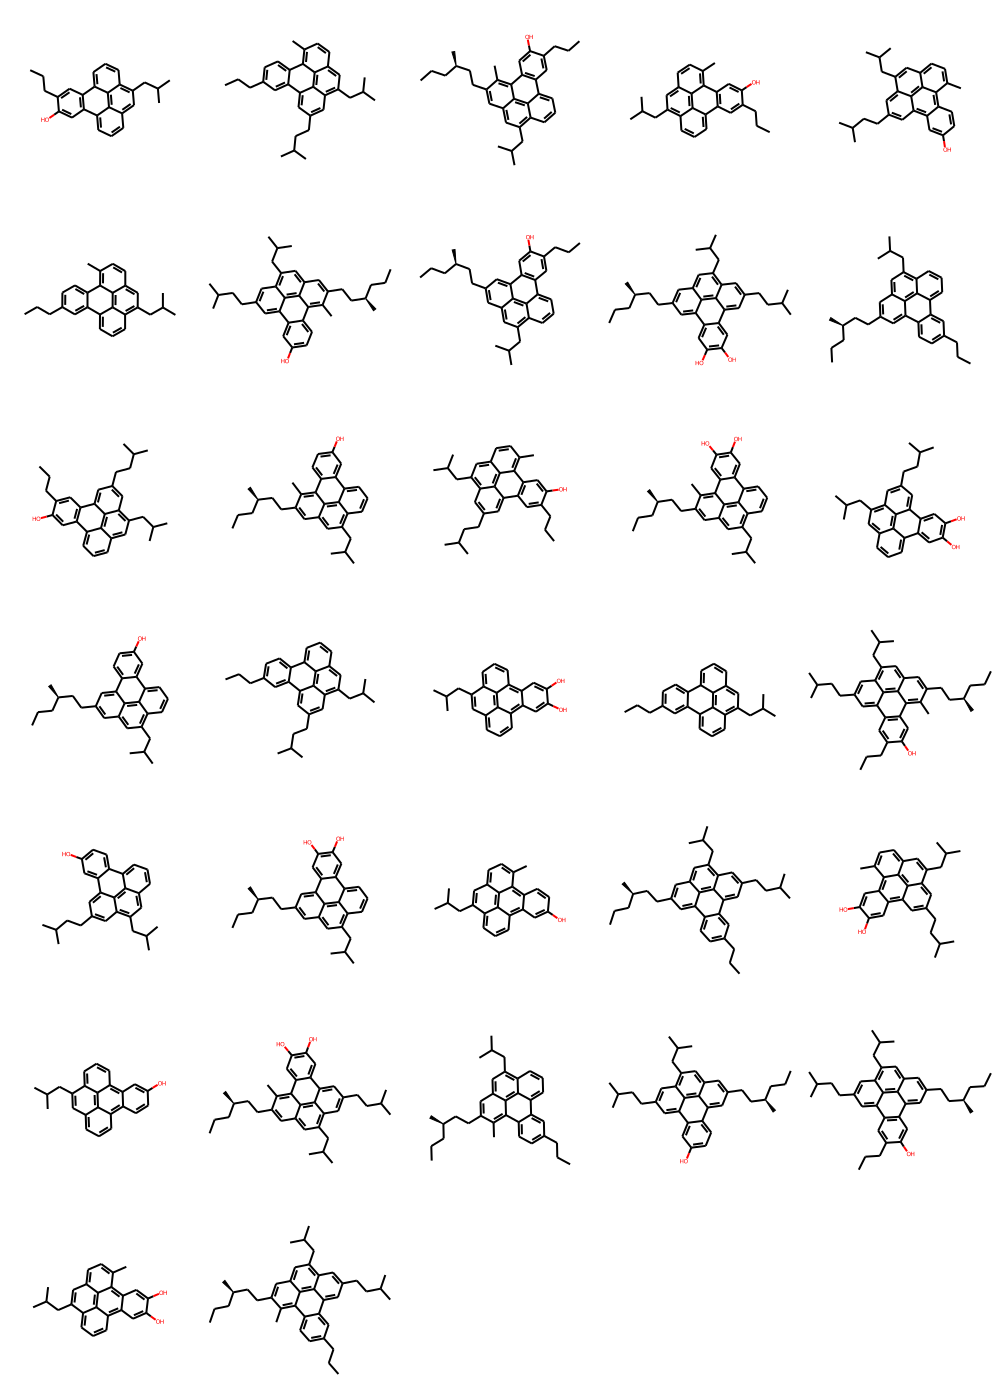

In [29]:
uniquemols=[]
for i in unique:
    uniquemols.append(Chem.MolFromSmiles(i))
print(len(uniquemols), "unique molecules generated")
Draw.MolsToGridImage(uniquemols[:100], molsPerRow=5)

In [85]:
pilform=[]
for i in uniquemols:
    pilform.append(Draw.MolToImage(i))
uniquemolscore2 = pd.DataFrame(pilform[:100],columns=['unique'])

In [86]:
uniquemolscore2

,unique
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...
5,<PIL.PngImagePlugin.PngImageFile image mode=RG...
6,<PIL.PngImagePlugin.PngImageFile image mode=RG...
7,<PIL.PngImagePlugin.PngImageFile image mode=RG...
8,<PIL.PngImagePlugin.PngImageFile image mode=RG...
9,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [100]:
import os, sys
from PIL import Image

for i in range(len(pilform)):
    f = 'mol'+ str(i)
    outfile = f + ".jpg"
    pilform[i].save(outfile)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [109]:

# Insert Multiple Images into Excel Cells with Python
# PULL IN FILENAMES AND TITLES INSTEAD OF ADDING MANUALLY

import xlsxwriter
import glob
import os
from natsort import natsorted

# create a new Excel file and add a worksheet
workbook = xlsxwriter.Workbook('excel_insert_images.xlsx')
worksheet = workbook.add_worksheet()

# resize cells
# worksheet.set_column('B1:B5', 7)
worksheet.set_column(first_col=0, last_col=0, width=10)
worksheet.set_column(first_col=1, last_col=1, width=7)
worksheet.set_default_row(45)

# images list
images = []
for filename in natsorted(glob.glob('Shapes/*.jpg')):
    images.append(filename)

# insert images
image_row = 0
image_col = 1
for image in images:
    worksheet.insert_image(image_row, 
                           image_col, 
                           image, 
                           {'x_scale':0.25, 'y_scale': 0.25, 
                            'x_offset': 0.1, 'y_offset': 0.1,
                            'positioning': 1.2}) 
    # positioning = 1 allows move and size with cells (may not always perform as expected)
    image_row += 1
    
# titles list
titles = []
for title in natsorted(glob.glob('Shapes/*.jpg')):
    titles.append(os.path.basename(title))

# insert titles
title_row = 0
title_col = 0
for title in titles:
    worksheet.write(title_row,
                    title_col,
                    title)
    title_row += 1

workbook.close()